# Лабораторная работа 5
# Решающие деревья и случайные леса

## Лабораторная 5.3. Изучение  процесса подбора гиперпараметров модели

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from time import time

Целевой датасет - `diabetes`. Модель - `Случайный лес`.

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

model = RandomForestClassifier()

data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/refs/heads/master/diabetes.csv', sep=',')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [11]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

### 1
Выполним процесс подбора гиперпараметров используя `Random Search` из библиотеки `Scikit-Learn`

In [12]:
from sklearn.model_selection import RandomizedSearchCV

distributions = {
    'max_depth': (3, 7, 10, 15, 20, 30, 47, 70, 90, 110),
    'max_features': (1, 2, 3, 4, 5, 6, 7, 8),
    'n_estimators': (3, 7, 10, 15, 20, 30, 47, 60, 80, 100),
}

start = time()
rand_search = RandomizedSearchCV(model, param_distributions=distributions, random_state=0).fit(X_train, y_train)
print('Время оптимизации: ', time() - start)
print('Лучшие параметры: ', rand_search.best_params_)

Время оптимизации:  4.1701438426971436
Лучшие параметры:  {'n_estimators': 47, 'max_features': 8, 'max_depth': 10}


Почти все параметры за исключением количества отличаются признаков от одиночно подобранных нами: `n_estimators` был равен `80`, `max_features` - `8`, `max_depth` - `20`.

### 2
Выполним подбор гиперпараметров, для той же модели используя алгоритм `TPE` и библиотеку `Hyperopt`

In [22]:
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, STATUS_OK

# Пространство параметров
space = {
    'n_estimators': hp.choice('n_estimators', [3, 7, 10, 15, 20, 30, 47, 60, 80, 100]),
    'max_depth': hp.choice('max_depth', [3, 7, 10, 15, 20, 30, 47, 70, 90, 110]),
    'max_features': hp.choice('max_features', [1, 2, 3, 4, 5, 6, 7, 8])
}

# Обучение и оценка
def objective(params):
    model = RandomForestClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        max_features=params['max_features'],
        random_state=42
    )
    return -cross_val_score(model, X, y, cv=3, scoring='accuracy').mean()

# Запуск оптимизации
start = time()
best = fmin(
    objective, 
    space, 
    algo=tpe.suggest, 
    max_evals=20, 
    rstate=np.random.default_rng(42)
)
print('Время оптимизации: ', time() - start)
print('Лучшие параметры: ', best)

100%|█████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.30trial/s, best loss: -0.765625]
Время оптимизации:  4.6602842807769775
Лучшие параметры:  {'max_depth': 1, 'max_features': 1, 'n_estimators': 9}


Итак, мы получили очень сомнительные результаты, сильно отличающиеся от предыдущих, за более долгое время.

### 3
Сравним точность моделей с подобранными параметрами.

In [26]:
from sklearn.metrics import f1_score, auc, roc_curve

In [27]:
model_rand_search = rand_search.best_estimator_

model_tpe = RandomForestClassifier(n_estimators=best['n_estimators'], max_depth=best['max_depth'], max_features=best['max_features'])
model_tpe.fit(X_train, y_train)

RandomForestClassifier(max_depth=1, max_features=1, n_estimators=9)

Сначала модель полученная из `RandomizedSearchCV`

f1_score =  0.6052631578947368
ROC-AUC =  0.7091036414565827


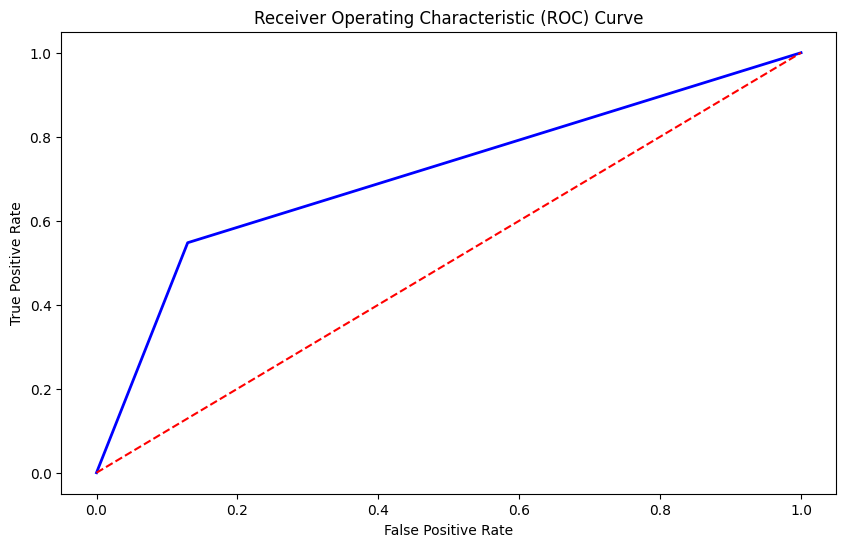

In [28]:
y_pred_best_params = model_rand_search.predict(X_test)

f1_score_best_params = f1_score(y_test, y_pred_best_params)

# Вычисление FPR и TPR
fpr, tpr, thresholds = roc_curve(y_test, y_pred_best_params)

# Вычисление площади под ROC-кривой
roc_auc = auc(fpr, tpr)

# Построение графика ROC-кривой
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Линия случайного выбора
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

print('f1_score = ', f1_score_best_params)
print('ROC-AUC = ', roc_auc)

Теперь модель обученная на параметрах полученных с помощью `Hyperopt`

f1_score =  0.15053763440860216
ROC-AUC =  0.5357843137254902


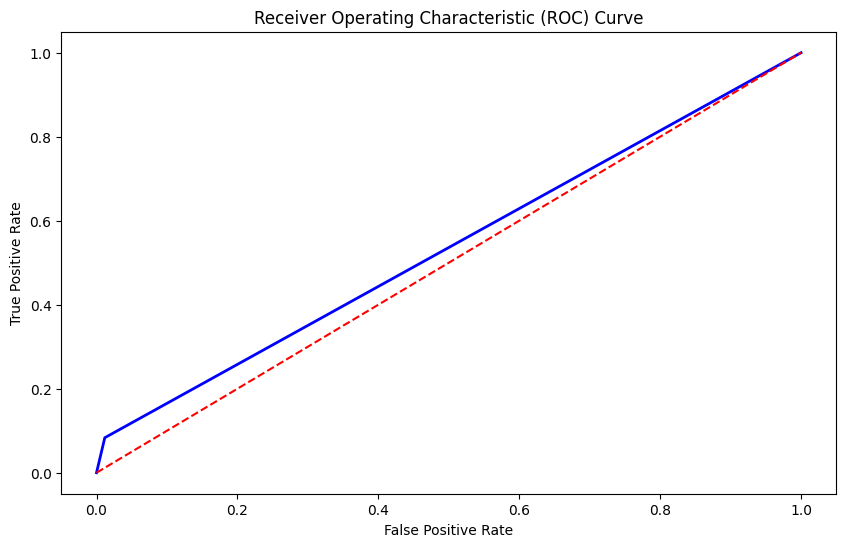

In [29]:
y_pred_best_params = model_tpe.predict(X_test)

f1_score_best_params = f1_score(y_test, y_pred_best_params)

# Вычисление FPR и TPR
fpr, tpr, thresholds = roc_curve(y_test, y_pred_best_params)

# Вычисление площади под ROC-кривой
roc_auc = auc(fpr, tpr)

# Построение графика ROC-кривой
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Линия случайного выбора
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

print('f1_score = ', f1_score_best_params)
print('ROC-AUC = ', roc_auc)

Полученная модель вообще не обладает никакой полезностью, так как имеет слишком плохие результаты, возможно, потому что нужно указать более широкий спекрт параметров.

Стоит отметить, что параметры, подобранные вручную оказались заметно лучше, чем параметры подобранные с помощью `RandomizedSearchCV`, что показывает, что `RandomizedSearchCV` не обеспечивает лучший набор параметров для нашей модели